# DeePC Experiment with L1 Regularization on Cartpole

## Create Simulation Environment

In [11]:
from CartpoleModel import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
from Controller import *
from itertools import product

%matplotlib inline

Ts = 0.1
params = np.ones(4)

cartpole = Cartpole(params)

sim = CartpoleSimulator(cartpole, Ts)

Xeq = np.zeros((4,1))
Xeq[1,0] = np.pi

Xeq

array([[0.        ],
       [3.14159265],
       [0.        ],
       [0.        ]])

## LQR Controller to stabilize unstable fixed point

In [12]:
A, B = cartpole.LinearisedDynamics()
C = np.eye(4)
D = np.zeros((4,1))

(Ad, Bd, *s) = cont2discrete((A,B,C,D), Ts, method='bilinear')

ctrl1 = Controller(Ad, Bd, params)

Q = np.array([[20, 0, 0, 0],
              [0, 20, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

R = np.eye(1)*5

K = ctrl1.K_LQR(Q, R)

In [173]:
theta0_array = np.linspace(-0.3, 0.3, 5)
x0_array = np.linspace(-1, 1, 5)

timesteps = 100

traj_LQR = np.zeros((25, 4, timesteps))
trajU_LQR = np.zeros((25, 1, timesteps))

i=0

for x0, theta0 in product(x0_array, theta0_array):

    X0 = Xeq + np.array([[x0],
                         [theta0],
                         [0],
                         [0]])
    
    full_state = np.squeeze(X0)

    for t in range(timesteps):

        fs = full_state[:, np.newaxis]
        
        u_ctrl = np.squeeze(K@(fs-Xeq)) + np.random.uniform(-0.2, 0.2)

        full_state = sim.step(full_state, u_ctrl)
        traj_LQR[i, :, t] = full_state
        trajU_LQR[i, :, t] = u_ctrl

    i+=1 

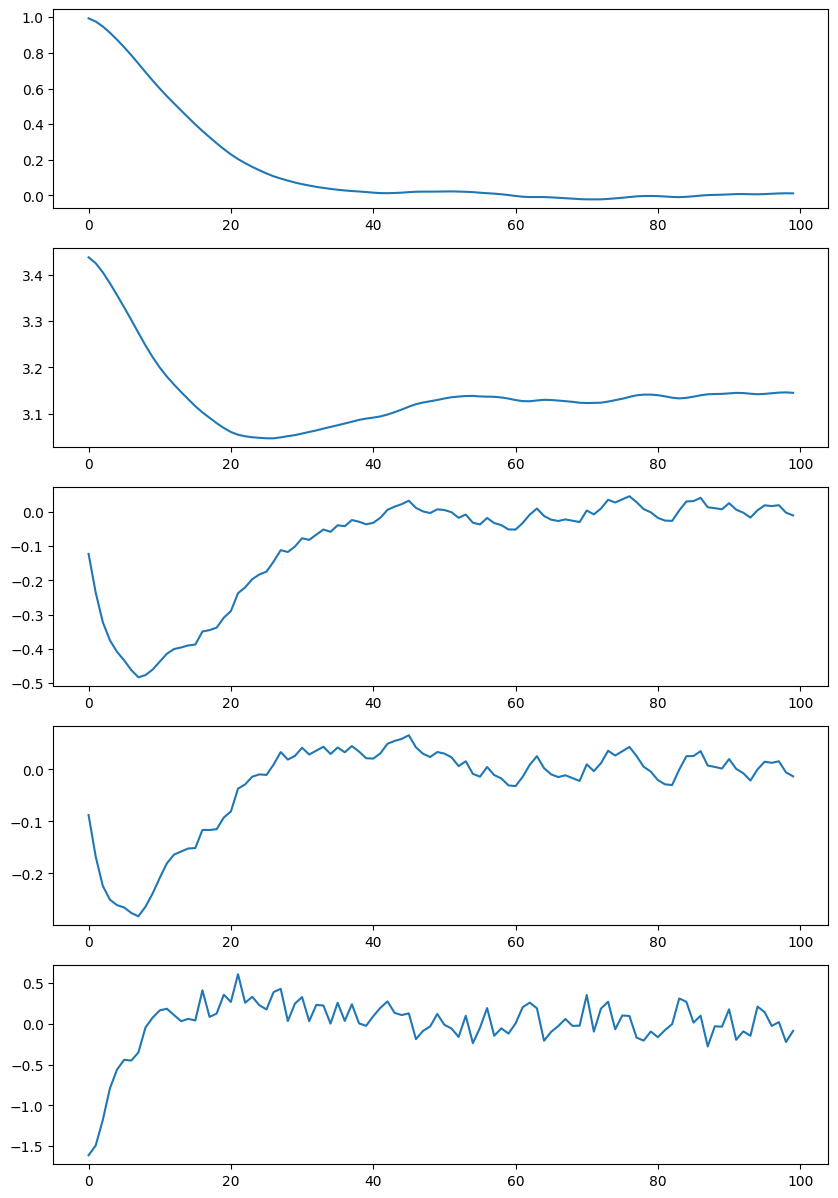

In [176]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs[0].plot(traj_LQR[24, 0, :])
axs[1].plot(traj_LQR[24, 1, :])
axs[2].plot(traj_LQR[24, 2, :])
axs[3].plot(traj_LQR[24, 3, :])
axs[4].plot(trajU_LQR[24, 0, :])

## Constructing Hankel Matrices from the Trajectories

In [187]:
from DeePC_utils import *
from DeePC import *

Tini = 2
L = 30
nx = 4
nu = 1

u_lim = (-2, 2)

Y = createHankel(traj_LQR[0, :, :], L, 100)
U = createHankel(trajU_LQR[0, :, :], L, 100)

for i in range(1, traj_LQR.shape[0]):

    Hx = createHankel(traj_LQR[i, :, :], L, 100)
    Hu = createHankel(trajU_LQR[i, :, :], L, 100)

    Y = mergedHankel((Y, Hx))
    U = mergedHankel((U, Hu))

In [188]:
Yp, Yf = splitHankel(Y, Tini, L, nx)
Up, Uf = splitHankel(U, Tini, L, nu)

In [189]:
Q = np.zeros(Yf.shape[0])
Q[::4] = 300
Q[1::4] = 300
Q[2::4] = 1
Q[3::4] = 1

R = np.ones(Uf.shape[0])
lamda_g = 30
lamda_s = 1e6

deepc = DeePC_Controller(Yp, Yf, Up, Uf)

prob, y_ini, u_ini, ref, g, uf = deepc.OneNormDeePC(Q, R, lamda_g, lamda_s, u_lim)

In [212]:
import numpy.matlib as mat
X0 = np.array([[0.0],
                [np.pi-0.12],
                [0.0],
                [0.0]])

target = np.array([[0],
                   [np.pi],
                   [0],
                   [0]])

reference = ReshapeTraj(mat.repmat(target, 1, L-Tini))
timesteps = 200
# reference[:20] = np.zeros((20,1))

full_state = np.squeeze(X0)

traj = np.zeros((4, timesteps))
trajU = np.zeros((1, timesteps))
traj_Tini = np.zeros((4, Tini)) + X0
trajU_Tini = np.zeros((1, Tini))

G = np.zeros((Yp.shape[1], timesteps))

In [213]:
for i in range(timesteps):

    # fs = full_state[:, np.newaxis]
    # reference = np.linspace(fs, target, L-Tini)

    y_ini.value = ReshapeTraj(traj_Tini)
    u_ini.value = ReshapeTraj(trajU_Tini)

    ref.value = reference
    # ref.value = giveReference(traj_ref, i, L-Tini)

    prob.solve(solver=cv.OSQP, warm_start=True)

    u_ctrl = uf.value[0, :]

    full_state = sim.step(full_state, np.squeeze(u_ctrl))
    
    traj[:, i] = full_state
    trajU[:, i] = u_ctrl

    G[:, i] = np.squeeze(g.value)

    traj_Tini = TimeShift(traj_Tini, full_state[:, np.newaxis])
    trajU_Tini = TimeShift(trajU_Tini, u_ctrl[:, np.newaxis])

C:\Users\rudra104\AppData\Roaming\Python\Python310\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


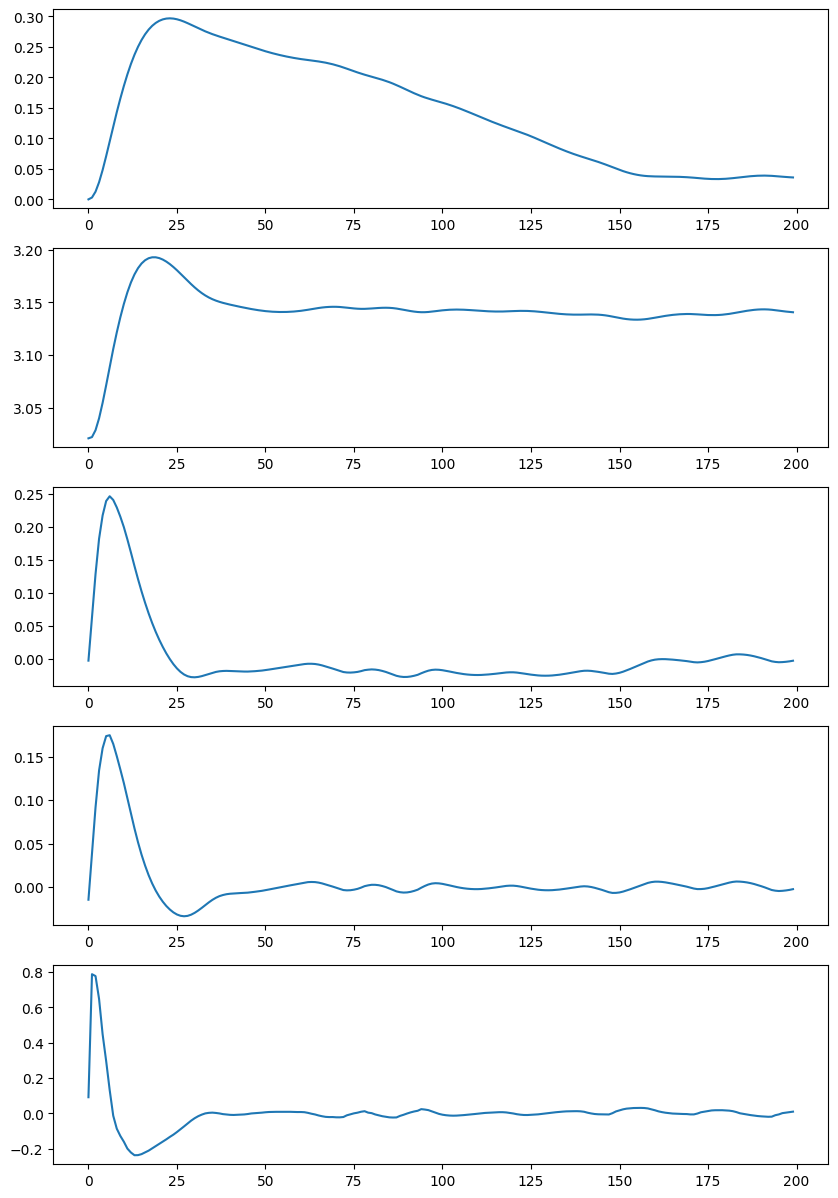

In [216]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs[0].plot(traj[0, :])
axs[1].plot(traj[1, :])
axs[2].plot(traj[2, :])
axs[3].plot(traj[3, :])
axs[4].plot(trajU[0, :])

<Axes: >

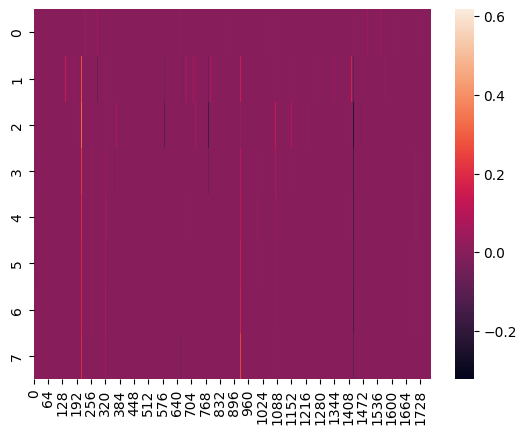

In [215]:
import seaborn as sns
sns.heatmap(G.T[:8, :])